## Prepare functions to train the svc model
### 1. Decide what features to use, maybe combination of color and gradient
###    For this problem, I will use combination of color and gradient(HOG)
### 2. Choose and train a classifier, not limited to linear SVM
###    For now I will use linear SVC, but will check if other method can improve the accuracy
### 3. Sliding windows to search vehicle in test images
###    Use multiple window size to sliding over the image
### 4. Use heatmap to filter out the false positive

In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pickle
import cv2
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from scipy.ndimage.measurements import label
from sklearn.model_selection import train_test_split
%matplotlib inline

In [2]:
def visualize(fig, rows, cols, imgs, titles):
    for i, img in enumerate(imgs):
        plt.subplot(rows, cols, i+1)
        plt.title(i+1)
        img_dims = len(img.shape)
        if img_dims < 3:
            plt.imshow(img, cmap='hot')
            plt.title(titles[i])
        else:
            plt.imshow(img)
            plt.title(titles[i])

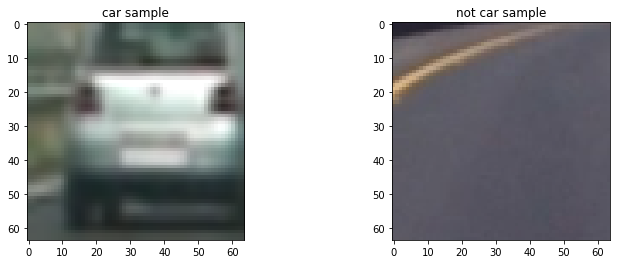

In [3]:
# Load the data and display examples from car and non-car
car_path = glob.glob('.\\training_images\\vehicles\\*\\*.png')
notcar_path = glob.glob('.\\training_images\\non-vehicles\\*\\*.png')

car_ind = 100
notcar_ind = 100
car_sample = mpimg.imread(car_path[car_ind])
notcar_sample = mpimg.imread(notcar_path[notcar_ind])

imgs = [car_sample, notcar_sample]
titles = ['car sample', 'not car sample']
fig = plt.figure(figsize=(12,4))
visualize(fig, 1, 2, imgs, titles)

## Inherit the functions from classes

In [4]:
def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)


def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                     vis=False, feature_vec=True):
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                                  visualise=True, feature_vector=feature_vec)
        return features, hog_image
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                       visualise=False, feature_vector=feature_vec)
        return features


def bin_spatial(image, size=(32, 32)):
    color1 = cv2.resize(image[:,:,0], size).ravel()
    color2 = cv2.resize(image[:,:,1], size).ravel() 
    color3 = cv2.resize(image[:,:,2], size).ravel() 
    return np.hstack((color1, color2, color3))

def color_hist(img, nbins=32):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

def extract_features(imgs, cspace='RGB', spatial_size=(32, 32),
                    hist_bins=32, orient=9, pix_per_cell=8, cell_per_block=2,
                    hog_channel=0, spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)
        
        if spatial_feat == True:
            # Apply bin_spatial() to get spatial color features
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
            # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel],
                                        orient, pix_per_cell, cell_per_block,
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient,
                                                pix_per_cell, cell_per_block, vis=False,
                                                feature_vec=True)
            #Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # return list of feature vectors
    return features

def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y NO BUFFER IN UTUBE VID
    #nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    #ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int(xspan/nx_pix_per_step) - 1
    ny_windows = np.int(yspan/ny_pix_per_step) - 1
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

# Draws a bounding box given a set of coordinates of opposite rectangle corners
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True, vis=False):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.concatenate(hog_features)
        else:
            if vis == True:
                hog_features, hog_image = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=True, feature_vec=True)
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    if vis == True:
        return np.concatenate(img_features), hog_image
    else:
        return np.concatenate(img_features)

# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

In [5]:
color_space = 'RGB'  # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8  # HOG pixels per cell
cell_per_block = 2  # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32)  # Spatial binning dimensions
hist_bins = 32  # Number of histogram bins
spatial_feat = True  # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True  # HOG features on or off

## Example of HOG

c:\users\zypch\appdata\local\programs\python\python36\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


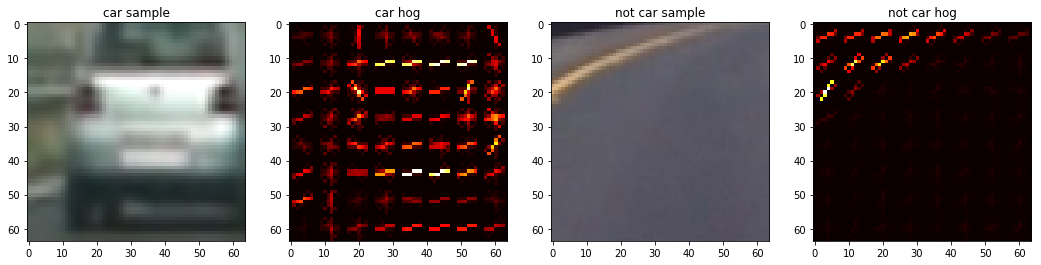

In [6]:
_, hog_image1 = get_hog_features(car_sample[:,:,0], orient, 
                        pix_per_cell, cell_per_block, vis=True, feature_vec=True)
_, hog_image2 = get_hog_features(notcar_sample[:,:,0], orient, 
                        pix_per_cell, cell_per_block, vis=True, feature_vec=True)
imgs = [car_sample,hog_image1, notcar_sample, hog_image2]
titles = ['car sample','car hog', 'not car sample', 'not car hog']
fig = plt.figure(figsize=(18,12))
visualize(fig, 1, 4, imgs, titles)

## Example of Spacital Bin

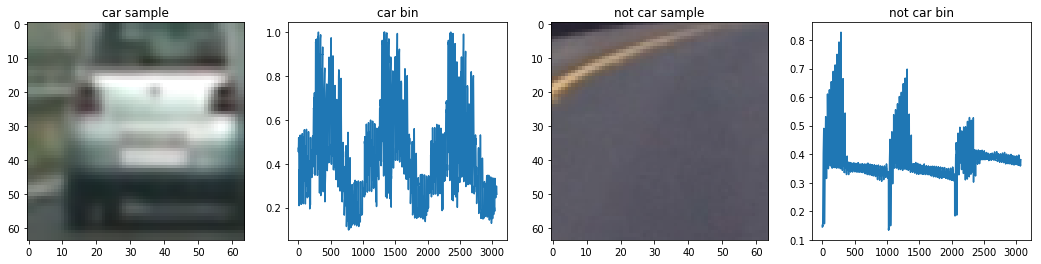

In [7]:
car_bin = bin_spatial(car_sample, size=spatial_size)
notcar_bin = bin_spatial(notcar_sample, size=spatial_size)
imgs = [car_sample,car_bin, notcar_sample, notcar_bin]
titles = ['car sample','car bin', 'not car sample', 'not car bin']
fig = plt.figure(figsize=(18,4))
for i, img in enumerate(imgs):
    plt.subplot(1, 4, i+1)
    plt.title(i+1)
    img_dims = len(img.shape)
    if i%2 == 0:
        plt.imshow(img)
        plt.title(titles[i])
    else:
        plt.plot(img)
        plt.title(titles[i])

## Example of Color Histogram

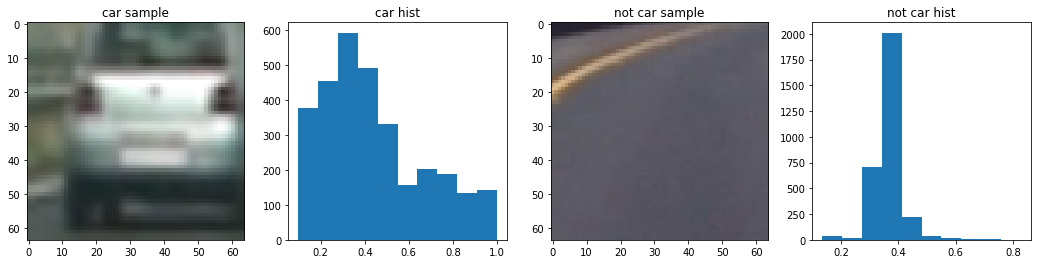

In [8]:
hist_features1 = color_hist(car_sample, nbins=hist_bins)
hist_features2 = color_hist(notcar_sample, nbins=hist_bins)
imgs = [car_sample,car_bin, notcar_sample, notcar_bin]
titles = ['car sample','car hist', 'not car sample', 'not car hist']
fig = plt.figure(figsize=(18,4))
for i, img in enumerate(imgs):
    plt.subplot(1, 4, i+1)
    plt.title(i+1)
    img_dims = len(img.shape)
    if i%2 == 0:
        plt.imshow(img)
        plt.title(titles[i])
    else:
        plt.hist(img)
        plt.title(titles[i])

## Feature Extraction Parameter Tuning 

In [9]:
from sklearn.utils import shuffle
test_cars, test_notcars = shuffle(car_path, notcar_path[:len(car_path)])
n_samples = 1000
test_cars = test_cars[:n_samples]
test_notcars = test_notcars[:n_samples]

def parameter_tuning(color_space=color_space, spatial_size=spatial_size,
                    hist_bins=hist_bins, orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block,
                    hog_channel=hog_channel, spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat):
    t=time.time()
    car_features = extract_features(test_cars, cspace=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
    notcar_features = extract_features(test_notcars, cspace=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

    print(np.round(time.time()-t, 2), ' seconds to compute features')
    
    X = np.vstack((car_features, notcar_features)).astype(np.float64)
    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X)
    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)

    # Define the labels vector
    y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

    # Split up data into randomized training and test sets
    rand_state = np.random.randint(0,100)
    X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, 
                                                    random_state=rand_state)

    print('Using: ',color_space,' color space and ',orient,'orientations and',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block and', 
     hist_bins, 'histogram bins, and', spatial_size, 'spatial sampling')
    print('Feature vector length:', len(X_train[0]))
    # Use a linear SVC 
    svc = LinearSVC()
    # Check the training time for the SVC
    t=time.time()
    svc.fit(X_train, y_train)
    t2 = time.time()
    print(np.round(t2-t, 2), 'Seconds to train SVC')
    # Check the score of the SVC
    print('Test Accuracy of SVC = ', np.round(svc.score(X_test, y_test), 5))
    print('______________________________________________________________________________________________________________________')

In [10]:
color_scan = ['RGB', 'HSV', 'YCrCb', 'LUV', 'YUV', 'HLS']
    
for each_cs in color_scan:
    parameter_tuning(color_space=each_cs)    

print("ALL DONE!!!!!!!!!")

c:\users\zypch\appdata\local\programs\python\python36\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


9.22  seconds to compute features
Using:  RGB  color space and  9 orientations and 8 pixels per cell and 2 cells per block and 32 histogram bins, and (32, 32) spatial sampling
Feature vector length: 8460
1.27 Seconds to train SVC
Test Accuracy of SVC =  0.9675
______________________________________________________________________________________________________________________
9.17  seconds to compute features
Using:  HSV  color space and  9 orientations and 8 pixels per cell and 2 cells per block and 32 histogram bins, and (32, 32) spatial sampling
Feature vector length: 8460
0.65 Seconds to train SVC
Test Accuracy of SVC =  0.9875
______________________________________________________________________________________________________________________
9.15  seconds to compute features
Using:  YCrCb  color space and  9 orientations and 8 pixels per cell and 2 cells per block and 32 histogram bins, and (32, 32) spatial sampling
Feature vector length: 8460
0.59 Seconds to train SVC
Test Acc

In [11]:
color_space = 'YCrCb'
pix_per_cell_scan = [8, 16, 32]
    
for each_cs in pix_per_cell_scan:
    parameter_tuning(pix_per_cell=each_cs)    

print("ALL DONE!!!!!!!!!") 

c:\users\zypch\appdata\local\programs\python\python36\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


8.93  seconds to compute features
Using:  RGB  color space and  9 orientations and 8 pixels per cell and 2 cells per block and 32 histogram bins, and (32, 32) spatial sampling
Feature vector length: 8460
1.11 Seconds to train SVC
Test Accuracy of SVC =  0.975
______________________________________________________________________________________________________________________
6.27  seconds to compute features
Using:  RGB  color space and  9 orientations and 16 pixels per cell and 2 cells per block and 32 histogram bins, and (32, 32) spatial sampling
Feature vector length: 4140
1.39 Seconds to train SVC
Test Accuracy of SVC =  0.975
______________________________________________________________________________________________________________________
6.25  seconds to compute features
Using:  RGB  color space and  9 orientations and 32 pixels per cell and 2 cells per block and 32 histogram bins, and (32, 32) spatial sampling
Feature vector length: 3276
2.62 Seconds to train SVC
Test Accur

In [12]:
pix_per_cell = 8
cell_per_block_scan = [1, 2, 3, 4]
    
for each_cs in cell_per_block_scan:
    parameter_tuning(cell_per_block=each_cs)    

print("ALL DONE!!!!!!!!!") 

c:\users\zypch\appdata\local\programs\python\python36\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


8.95  seconds to compute features
Using:  RGB  color space and  9 orientations and 8 pixels per cell and 1 cells per block and 32 histogram bins, and (32, 32) spatial sampling
Feature vector length: 4896
0.78 Seconds to train SVC
Test Accuracy of SVC =  0.98
______________________________________________________________________________________________________________________
9.25  seconds to compute features
Using:  RGB  color space and  9 orientations and 8 pixels per cell and 2 cells per block and 32 histogram bins, and (32, 32) spatial sampling
Feature vector length: 8460
1.1 Seconds to train SVC
Test Accuracy of SVC =  0.97
______________________________________________________________________________________________________________________
8.11  seconds to compute features
Using:  RGB  color space and  9 orientations and 8 pixels per cell and 3 cells per block and 32 histogram bins, and (32, 32) spatial sampling
Feature vector length: 11916
1.42 Seconds to train SVC
Test Accuracy 

In [13]:
cell_per_block = 3
hog_channel_scan = [0, 1, 2, "ALL"]
    
for each_cs in hog_channel_scan:
    parameter_tuning(hog_channel=each_cs)    

print("ALL DONE!!!!!!!!!") 


c:\users\zypch\appdata\local\programs\python\python36\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


4.42  seconds to compute features
Using:  RGB  color space and  9 orientations and 8 pixels per cell and 2 cells per block and 32 histogram bins, and (32, 32) spatial sampling
Feature vector length: 4932
0.92 Seconds to train SVC
Test Accuracy of SVC =  0.9625
______________________________________________________________________________________________________________________
4.33  seconds to compute features
Using:  RGB  color space and  9 orientations and 8 pixels per cell and 2 cells per block and 32 histogram bins, and (32, 32) spatial sampling
Feature vector length: 4932
0.95 Seconds to train SVC
Test Accuracy of SVC =  0.97
______________________________________________________________________________________________________________________
4.29  seconds to compute features
Using:  RGB  color space and  9 orientations and 8 pixels per cell and 2 cells per block and 32 histogram bins, and (32, 32) spatial sampling
Feature vector length: 4932
0.96 Seconds to train SVC
Test Accurac

In [14]:
hog_channel = "ALL"
spatial_size_scan = [(8, 8), (16, 16), (32, 32),  (64, 64)] 
    
for each_cs in spatial_size_scan:
    parameter_tuning(spatial_size=each_cs)    

print("ALL DONE!!!!!!!!!") 


c:\users\zypch\appdata\local\programs\python\python36\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


9.06  seconds to compute features
Using:  RGB  color space and  9 orientations and 8 pixels per cell and 2 cells per block and 32 histogram bins, and (8, 8) spatial sampling
Feature vector length: 5580
0.64 Seconds to train SVC
Test Accuracy of SVC =  0.975
______________________________________________________________________________________________________________________
9.07  seconds to compute features
Using:  RGB  color space and  9 orientations and 8 pixels per cell and 2 cells per block and 32 histogram bins, and (16, 16) spatial sampling
Feature vector length: 6156
0.65 Seconds to train SVC
Test Accuracy of SVC =  0.9725
______________________________________________________________________________________________________________________
9.11  seconds to compute features
Using:  RGB  color space and  9 orientations and 8 pixels per cell and 2 cells per block and 32 histogram bins, and (32, 32) spatial sampling
Feature vector length: 8460
1.06 Seconds to train SVC
Test Accuracy

In [15]:
spatial_size = (32, 32)
hist_bins_scan =[8, 16, 32] 
    
for each_cs in hist_bins_scan:
    parameter_tuning(hist_bins=each_cs)    

print("ALL DONE!!!!!!!!!") 

c:\users\zypch\appdata\local\programs\python\python36\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


9.01  seconds to compute features
Using:  RGB  color space and  9 orientations and 8 pixels per cell and 2 cells per block and 8 histogram bins, and (32, 32) spatial sampling
Feature vector length: 8388
1.11 Seconds to train SVC
Test Accuracy of SVC =  0.9675
______________________________________________________________________________________________________________________
8.91  seconds to compute features
Using:  RGB  color space and  9 orientations and 8 pixels per cell and 2 cells per block and 16 histogram bins, and (32, 32) spatial sampling
Feature vector length: 8412
1.18 Seconds to train SVC
Test Accuracy of SVC =  0.9625
______________________________________________________________________________________________________________________
8.92  seconds to compute features
Using:  RGB  color space and  9 orientations and 8 pixels per cell and 2 cells per block and 32 histogram bins, and (32, 32) spatial sampling
Feature vector length: 8460
1.02 Seconds to train SVC
Test Accura

## Final Feature Parameters 

In [16]:
color_space = 'YCrCb'
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = 'ALL'
spatial_size = (32, 32)
hist_bins = 32
spatial_feat = True
hist_feat = True
hog_feat = True

## Extract Features and Store to Prevent Repeat Calculation

In [17]:
t = time.time()

car_features = extract_features(car_path, cspace=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcar_path, cspace=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
    
X = np.vstack((car_features, notcar_features)).astype(np.float64)
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

t2 = time.time()
print(round(t2 - t, 0), 'seconds to extract the features.')

# Process data and save as pickle file
Xy_features = {'X_feature': X, 'y_feature':y}

file_Name = "store_features.p"
# open the file for writing
fileObject = open(file_Name,'wb') 

# this writes the object a to the
pickle.dump(Xy_features,fileObject)   

# here we close the fileObject
fileObject.close()

c:\users\zypch\appdata\local\programs\python\python36\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


88.0 seconds to extract the features.


## Train The Model

In [18]:
## load the saved features data

# dist_pickle = pickle.load(open("store_features.p", "rb"))
# X = dist_pickle['X_feature']
# y = dist_pickle['y_feature']

# # Split up data into randomized training and test sets
# # Train the model 

# # Split up data into randomized training and test sets
rand_state = np.random.randint(0,100)
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, 
                                                    random_state=rand_state)

print('Using:',orient,'orientations and',pix_per_cell,
'pixels per cell and', cell_per_block,'cells per block and', 
hist_bins, 'histogram bins, and', spatial_size, 'spatial sampling')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
t = time.time()
svc.fit(X_train, y_train)

t2 = time.time()
print(round(t2 - t, 0), 'seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t = time.time()

Using: 9 orientations and 8 pixels per cell and 2 cells per block and 32 histogram bins, and (32, 32) spatial sampling
Feature vector length: 8460
6.0 seconds to train SVC...
Test Accuracy of SVC =  0.9907


## Save Trained Model

In [19]:
# temp = {'svc':svc,
#         'color_space': color_space,
#         'orient':  orient,
#         'pix_per_cell':  pix_per_cell,
#         'cell_per_block':  cell_per_block,
#         'hog_channel':  hog_channel,
#         'spatial_size':  spatial_size,
#         'hist_bins':  hist_bins,
#         'spatial_feat':  spatial_feat,
#         'hist_feat':  hist_feat,
#         'hog_feat':  hog_feat,
#         'X_scaler': X_scaler}
# # file_Name = "trained_svc.p"
# # open the file for writing
# fileObject = open('trained_svc.p', 'wb') 

# # this writes the object a to the
# pickle.dump(temp, fileObject)   

# # here we close the fileObject
# fileObject.close()

## Load Trained Model

In [20]:
# ## load the trained model
# svc_pickle = pickle.load(open("trained_svc.p", "rb"))
# svc = svc_pickle['svc']
# color_space = svc_pickle['color_space']
# orient = svc_pickle['orient']
# pix_per_cell = svc_pickle['pix_per_cell']
# cell_per_block = svc_pickle['cell_per_block']
# hog_channel = svc_pickle['hog_channel']
# spatial_size = svc_pickle['spatial_size']
# hist_bins = svc_pickle['hist_bins']
# spatial_feat = svc_pickle['spatial_feat']
# hist_feat = svc_pickle['hist_feat']
# hog_feat = svc_pickle['hog_feat']
# X_scaler = svc_pickle['X_scaler']

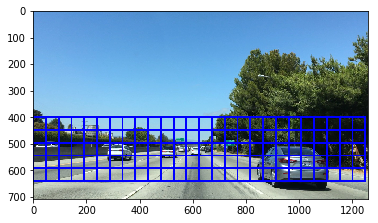

In [21]:
y_start_stop=[400, 656]
overlap = 0.5
xy_overlap=(overlap, overlap)

test_image = mpimg.imread('.\\test_images\\test3.jpg')
windows = slide_window(test_image, y_start_stop=y_start_stop,
                       xy_window=(96,96), xy_overlap=xy_overlap)
plt.imshow(draw_boxes(test_image, windows))

c:\users\zypch\appdata\local\programs\python\python36\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


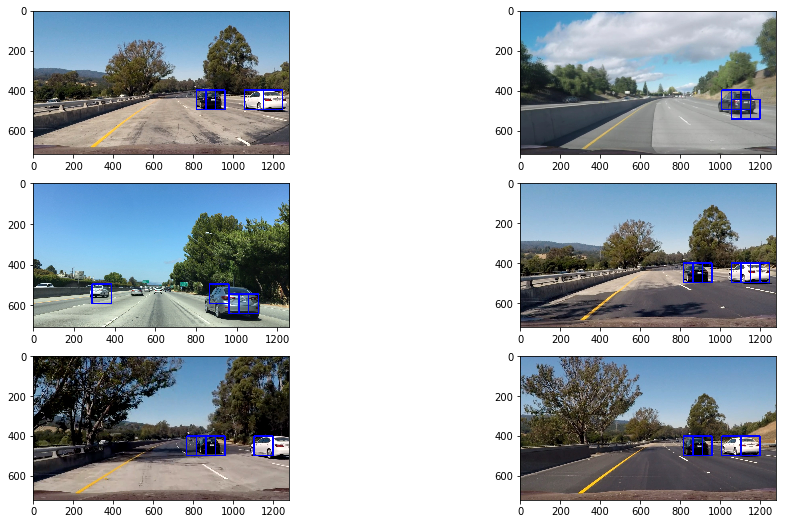

In [22]:
searchpath = 'test_images/*'
example_images = glob.glob(searchpath)
images = []
titles = []
y_start_stop = [400, 656] # Min & Max in y to search in slide_window()
overlap = 0.5
for img_src in example_images:
    t1 = time.time()
    img = mpimg.imread(img_src)
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255        
    windows = slide_window(img, x_start_stop=[None, None], y_start_stop=y_start_stop,
                               xy_window=(96,96), xy_overlap=(overlap,overlap))
    hot_windows = search_windows(img, windows, svc, X_scaler, color_space=color_space,
                                    spatial_size=spatial_size, hist_bins=hist_bins, orient=orient,
                                    pix_per_cell=pix_per_cell, cell_per_block=cell_per_block,
                                    hog_channel=hog_channel, spatial_feat=spatial_feat,
                                    hist_feat=hist_feat, hog_feat=hog_feat)
        
    window_img = draw_boxes(draw_img, hot_windows, color=(0, 0 ,255), thick=6)
    images.append(window_img)
    titles.append('')
fig = plt.figure(figsize=(16,9))
visualize(fig,3,2,images,titles)

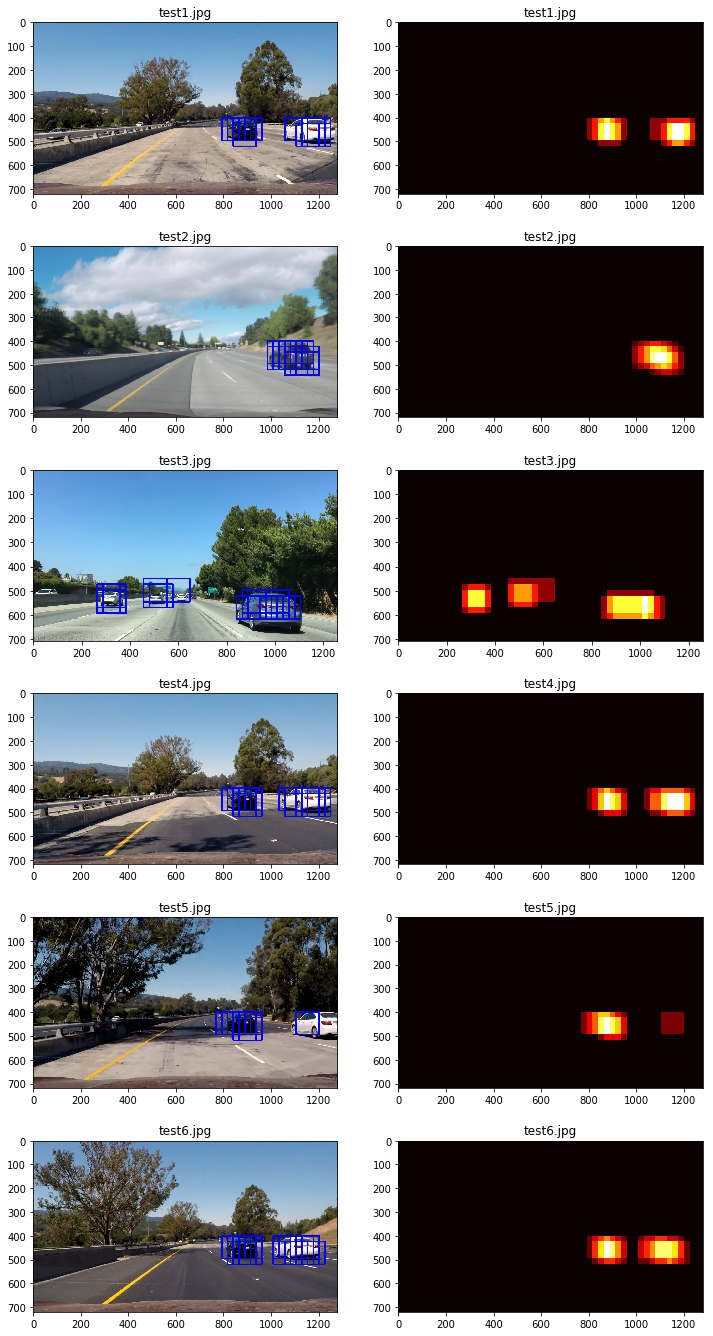

In [30]:
out_images = []
out_maps = []
out_titles = []
out_boxes = []
ystart, ystop = y_start_stop[0], y_start_stop[1]
scale = 1.5

#Iterate over test images
for img_src in example_images:
    img_boxes = []
    t=time.time()
    count=0
    img = mpimg.imread(img_src)
    draw_img = np.copy(img)
    # Make a heat map of zeros
    heatmap=np.zeros_like(img[:,:,0])
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
    
    ch1=ctrans_tosearch[:,:,0]
    ch2=ctrans_tosearch[:,:,1]
    ch3=ctrans_tosearch[:,:,2]

    #define blocks and steops as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - 1
    nfeat_per_block = orient*cell_per_block**2
    window = 64
    nblocks_per_window = (window // pix_per_cell) - 1
    cells_per_step = 2 # Instead of overlap, define how man cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    #Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            count += 1
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            
            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell
            
            #Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
            
            #Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)
            
            #Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))
            test_prediction = svc.predict(test_features)
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img, (xbox_left, ytop_draw+ystart), (xbox_left+win_draw, ytop_draw+win_draw+ystart),(0,0,255),6)
                img_boxes.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                heatmap[ytop_draw+ystart:ytop_draw+win_draw+ystart, xbox_left:xbox_left+win_draw] += 1
                
    out_images.append(draw_img)
        
    out_titles.append(img_src[-9:])
    out_titles.append(img_src[-9:])
    out_images.append(heatmap)
    out_maps.append(heatmap)
    out_boxes.append(img_boxes)

fig = plt.figure(figsize=(12,24))
visualize(fig, 6, 2, out_images, out_titles)

In [24]:
def find_cars(img, scale):
    img_boxes = []
    draw_img = np.copy(img)
    # Make a heat map of zeros
    heatmap=np.zeros_like(img[:,:,0])
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
    
    ch1=ctrans_tosearch[:,:,0]
    ch2=ctrans_tosearch[:,:,1]
    ch3=ctrans_tosearch[:,:,2]

    #define blocks and steops as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - 1
    nfeat_per_block = orient*cell_per_block**2
    window = 64
    nblocks_per_window = (window // pix_per_cell) - 1
    cells_per_step = 2 # Instead of overlap, define how man cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    #Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            
            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell
            
            #Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
            
            #Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)
            
            #Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))
            test_prediction = svc.predict(test_features)
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                img_boxes.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                        
    return img_boxes
    

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1  # along row, then along column

    # Return updated heatmap
    return heatmap  # Iterate through list of bboxes


def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap


def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1] + 1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0, 0, 255), 6)
    # Return the image
    return img


from collections import deque
b_boxes_deque = deque(maxlen=30)

def add_heat_video(heatmap, b_boxes_deque):
    # Iterate through list of bboxes
    for bbox_list in b_boxes_deque:
        for box in bbox_list:
            # Add += 1 for all pixels inside each bbox
            # Assuming each "box" takes the form ((x1, y1), (x2, y2))
            heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
    # Return updated heatmap
    return heatmap

def image_pipeline(img):
    
    b_boxes = find_cars(img, scale = 1.5)
    b_boxes_deque.append(b_boxes)
    
    heat = np.zeros_like(img[:,:,0]).astype(np.float)

    add_heat_video(heat, b_boxes_deque)

    # Apply threshold to remove false positive and ensure only recurring cars in the frame are detected
    heat = apply_threshold(heat, 22)

    heatmap = np.clip(heat, 0, 255)

    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(img), labels)

    return draw_img

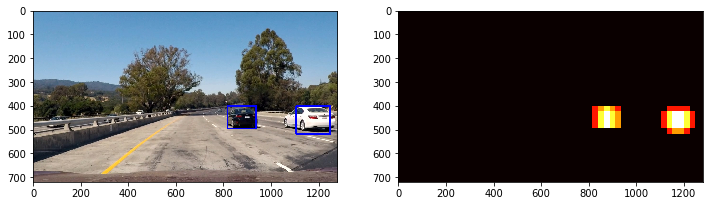

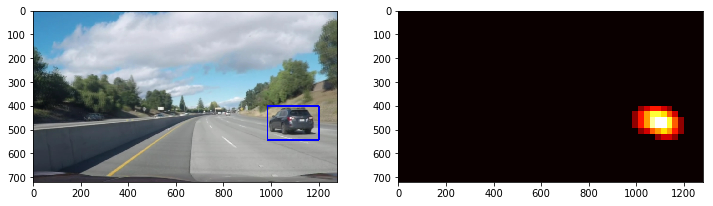

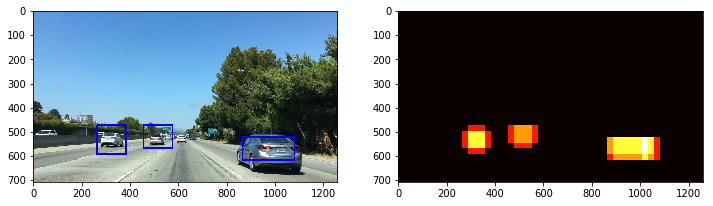

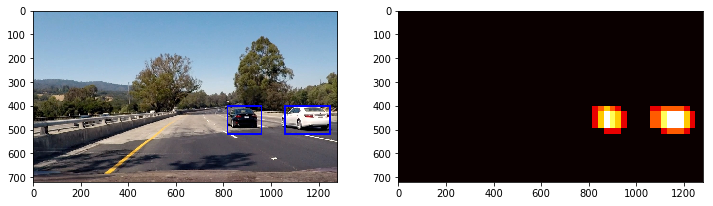

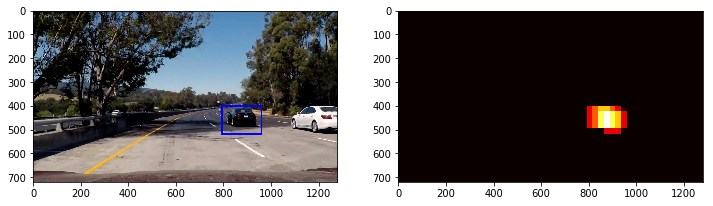

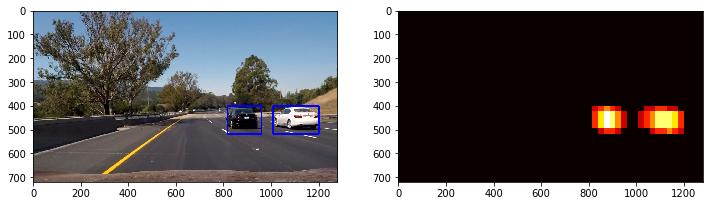

In [29]:
#Iterate over test images
for img_src in example_images:
    img = mpimg.imread(img_src)
    out_img = find_cars(img, scale)

    heat_map = np.zeros_like(img[:,:,0]).astype(np.float)
    #out_img, heat_map = find_cars(img, scale)
    add_heat(heat_map, out_img)
    heat_map = apply_threshold(heat_map, 1)
    heat_map = np.clip(heat_map, 0 , 255)
    labels = label(heat_map)
    #Draw bounding boxes on a copy of the image
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    #out_images.append(draw_img)
    #out_images.append(heat_map)
    
    plt.figure(figsize=(12,18))
    plt.subplot(121)
    plt.imshow(draw_img)
    plt.subplot(122)
    plt.imshow(heat_map, cmap='hot')

In [26]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
white_output = 'project_video_output.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
# clip1 = VideoFileClip("project_video.mp4").subclip(40, 45)
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(image_pipeline) #NOTE: this function expects color images!!
white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [08:04<00:00,  2.60it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 



In [27]:
from IPython.display import HTML
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))